In [1]:
#basic package
import tqdm
import os
import numpy as np
import glob
import pandas as pd
import sys
import time
import datetime as dt
import itertools
import re
import math
from collections import Counter
import operator
from scipy import stats
from numpy import inf
import networkx as nx
from dtaidistance import dtw

#scaling
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#PCA
from sklearn import decomposition

#clustering
from sklearn.cluster import KMeans #only numerical var
from sklearn.metrics import silhouette_samples, silhouette_score
import kmodes
from kmodes.kmodes import KModes #with categorical var as well

#plot
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

In [2]:
PACKAGE_PARENT = '../'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd(), os.path.expanduser('__file__'))))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))
from UTILS import kmeans_clustering, ZoneVariable, time_series_henColumn_tsRow, FB_daily, corr_from_dep2feature,\
corr_from_feature2feature, correlationGraph, ZoneVariable, DataRepresentation1, sampen, chi2_distance, is_day
import config_origins as config

C:\Users\camil\anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


# Define parameters

In [3]:
print('change the configuration file if not done yet!')
path_extracted_data = config.path_extracted_data
id_run = config.id_run
dico_pen_tr = config.dico_pen_tr
li_binmn = config.li_binmn
path_extracted_data_visual = os.path.join(path_extracted_data,'visual')
path_extracted_data_visual_adap = os.path.join(path_extracted_data,'visual','Treatment&Classs','adaptability')
path_extracted_data_visual_adap_verification = os.path.join(path_extracted_data_visual_adap,'verification')
#create a director if not existing
if not os.path.exists(path_extracted_data_visual_adap_verification):
    os.makedirs(path_extracted_data_visual_adap_verification)

change the configuration file if not done yet!


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
#initialize parameters used in this notebook only
max_date = dt.datetime(2020,11,22)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Download variables

In [6]:
#focal birds information (one row per focal bird)
df_FB = pd.read_csv(os.path.join(path_extracted_data,id_run+'df_FOCALBIRDS.csv'), sep=';',
                    parse_dates=['InitialStartDate'], dayfirst=True)
print(df_FB.shape)
df_FB.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(211, 11)


,HenID,PenID,CLASS,R-Pen,InitialStartDate,29-09 weight,10-12 juin weight,weight 23-11-2020,weight 04-01-2021,weight 01-02-21,Treatment
0,hen_1,9,EPI,1.0,2020-06-10,1134.0,57.0,1696.5,1787.8,1800.9,OFH
1,hen_10,11,LEXP,1.0,2020-06-10,1070.0,70.4,1488.3,1628.4,1602.1,OFH
2,hen_100,5,EPI,3.0,2020-06-10,1182.0,80.5,1642.5,NaN,NaN,OFH


In [7]:
#cleaned data of the tracking system movements
df = pd.read_csv(os.path.join(path_extracted_data, id_run+'_CLEANEDDATA.csv'), sep=';', 
                 parse_dates=['Timestamp', 'date'], dayfirst=True) 
df = df[df['Timestamp']<=max_date]
df['hour'] = df['Timestamp'].map(lambda x: x.hour)
df['time'] = df['Timestamp'].map(lambda x: dt.datetime.time(x-dt.timedelta(seconds=x.second)))
df.drop('duration', axis=1, inplace=True)
print(df.shape)
df.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(340702, 17)


,HenID,PenID,system,Zone,model_prediction,Timestamp,date,next_record_date,previous_record_date,previous_duration,next_zone,previous_zone,previous_previous_zone,correction_is_consecutive_equal_initial_zone,is_WG_open,hour,time
0,hen_111,pen11,10 - 12,3_Zone,1.0,2020-09-30 00:01:25,2020-09-30,2020-09-30 00:01:38.000,NaN,NaN,2_Zone,NaN,NaN,False,False,0,00:01:00
1,hen_111,pen11,10 - 12,2_Zone,1.0,2020-09-30 00:01:38,2020-09-30,2020-09-30 00:14:38.000,2020-09-30 00:01:25.000,0 days 00:00:13,2_Zone,3_Zone,NaN,False,False,0,00:01:00
2,hen_147,pen8,8 - 9,5_Zone,1.0,2020-09-30 00:30:49,2020-09-30,2020-09-30 00:33:26.000,NaN,NaN,5_Zone,NaN,NaN,False,False,0,00:30:00


In [114]:
#daily variables of the movements (one row per available hen per day)
df_daily = pd.read_csv(os.path.join(path_extracted_data, 'daily_ALL_Variable_Tranformed.csv'), sep=';',
                     parse_dates=['level'], dayfirst=True) 
df_daily['DOA'] = df_daily['level'].map(lambda x: (x-dt.datetime(2020,6,3)).days) 
df_daily['WOA'] = df_daily['DOA'].map(lambda x: math.ceil(x/7))
#first two month seems good from the %of hens not moving plot! and sounds good too (twice longer thatn they need to start moving)
print(df_daily.shape)
df_daily = df_daily[(df_daily['level']>dt.datetime(2020,9,29))&(df_daily['level']<=max_date)] 
#df_daily.groupby(['PenID'])['Treatment'].agg(lambda x: set(x)).reset_index()
print(df_daily.shape)
display(df_daily[['level','DOA','WOA']].tail(3))
print(df_daily.shape)
df_daily.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(24452, 194)
(8590, 194)


,level,DOA,WOA
24444,2020-10-03,122,18
24445,2020-10-04,123,18
24446,2020-10-05,124,18


(8590, 194)


,HenID,level,duration_1_Zone,duration_2_Zone,duration_3_Zone,duration_4_Zone,duration_5_Zone,verification_daily_total_duration,dur_values,dur_values_normalized,...,clustering_WG,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,clustering_ALL
0,hen_130,2020-10-04,0.0,140.0,1166.0,79.0,30613.0,31998.0,"[0.0, 140.0, 1166.0, 79.0, 30613.0]","[0.0, 0.004375273454590912, 0.0364397774860928...",...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,hen_130,2020-10-05,0.0,0.0,0.0,0.0,32400.0,32400.0,"[0.0, 0.0, 0.0, 0.0, 32400.0]","[0.0, 0.0, 0.0, 0.0, 1.0]",...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,hen_130,2020-10-06,0.0,0.0,780.0,325.0,31295.0,32400.0,"[0.0, 0.0, 780.0, 325.0, 31295.0]","[0.0, 0.0, 0.024074074074074074, 0.01003086419...",...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [115]:
min(df_daily['DOA'].tolist()), max(df_daily['DOA'].tolist())

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(119, 172)

In [116]:
min(df_daily['WOA'].tolist()), max(df_daily['WOA'].tolist())

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(17, 25)

In [117]:
mi = min(df_daily['DOA'].tolist())
ma = max(df_daily['DOA'].tolist())
print('We are involving a period of %d days of tracking during the days from the DOA %d until DOA %d'%(ma-mi, mi, ma))

We are involving a period of 53 days of tracking during the days from the DOA 119 until DOA 172


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# choose subset of hens

In [118]:
df_doa = df_daily[['level','DOA','WOA']].drop_duplicates()
df_doa.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,level,DOA,WOA
0,2020-10-04,123,18
1,2020-10-05,124,18
2,2020-10-06,125,18


In [119]:
#remove the days where the night had movement recorded but not the days
print(df_daily.shape)
df_daily = df_daily[['HenID','PenID','level','CLASS','Treatment','DOA','WOA','dur_values','dur_values_normalized','perc_duration_1_Zone', 'perc_duration_2_Zone',
          'perc_duration_3_Zone', 'perc_duration_4_Zone', 'perc_duration_5_Zone','Total_number_transition']]
#display(df_daily[df_daily.isna().any(axis=1)])
df_daily = df_daily[~df_daily.isna().any(axis=1)]
print(df_daily.shape)

(8590, 194)
(7532, 15)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [120]:
df_ = df_daily.groupby(['HenID'])[['Total_number_transition','level']].agg(lambda x: list(x)).reset_index()
df_['nbr_days_involved'] = df_['Total_number_transition'].map(lambda x: len(x))
df_['nbr_day_notransition'] = df_['Total_number_transition'].map(lambda x: sum([i==0 for i in x]))
df_['has_at_least_one_day_notransition'] = df_['nbr_day_notransition'].map(lambda x: x>0)
df_['always_more_5tran'] = df_['Total_number_transition'].map(lambda x: all([i>=5 for i in x]))
df_['min_nbr_tr'] = df_['Total_number_transition'].map(lambda x: min(x))
df_.to_csv(os.path.join(path_extracted_data_visual_adap ,id_run+'_df_4_hen_selection.csv'), sep=';', index=False)
print(df_.shape)
df_.head(1)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(175, 8)


,HenID,Total_number_transition,level,nbr_days_involved,nbr_day_notransition,has_at_least_one_day_notransition,always_more_5tran,min_nbr_tr
0,hen_1,"[6.0, 12.0, 2.0, 5.0, 2.0, 0.0, 0.0, 8.0, 0.0,...","[2020-09-30 00:00:00, 2020-10-01 00:00:00, 202...",49,17,True,False,0.0


In [121]:
#TODO: verify each birds!!!!!!!!!!!!!!!!!!! why here or not

#### take birds that have their mvt recorded on the 1.10.2020 (i.e. exclude the epigenetic ones that arrived on the 8th)
#note that some birds had their first mvt recorded after the day time on the 29.09, thus for those they wont have the chi2
#but still could have the DTW if we have no reason to think that these tags were activated with a delay
li_hen_selected1 = df_daily[df_daily['level']==dt.datetime(2020,10,1)]['HenID'].tolist()

#### also exclude the birds that were collected for epigenetic on the 8th of october by selecting all birds with at least 45days
min_days = 40  #we dont want to include hens that started on the 8.10.2020 after epigenetic collection
li_selected_hens2 = df_[df_['nbr_days_involved']>min_days]['HenID'].tolist()
li_selected_hens = [i for i in li_hen_selected1 if i in li_selected_hens2]
print('Lets consider %d hens'%len(li_selected_hens))

Lets consider 128 hens


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [123]:
li_hen_NoMvt = df_[(df_['has_at_least_one_day_notransition'])&(df_['HenID'].isin(li_selected_hens))]
li_hen_Mvt = df_[(~df_['has_at_least_one_day_notransition'])&(df_['HenID'].isin(li_selected_hens))]
print(len(li_hen_NoMvt), len(li_hen_Mvt))
print('%d percent of the hens have at least one day without any movements recorded'%(len(li_hen_NoMvt)/(len(li_hen_Mvt)+len(li_hen_NoMvt))*100))

66 62
51 percent of the hens have at least one day without any movements recorded


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [124]:
print(df_daily.shape)
df_daily = df_daily[df_daily['HenID'].isin(li_selected_hens)]
print(df_daily.shape)

(6164, 15)
(6164, 15)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [125]:
df_daily['PenID'].value_counts()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


10    859
11    807
3     806
8     775
9     774
12    753
4     752
5     638
Name: PenID, dtype: int64

In [126]:
#small verification
#df_daily[['HenID','level','dur_values','dur_values_normalized','perc_duration_1_Zone', 'perc_duration_2_Zone',
# 'perc_duration_3_Zone', 'perc_duration_4_Zone', 'perc_duration_5_Zone']]

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## understand the data visually

In [127]:
df_plt['CLASS'].unique()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array(['unknown', 'LEXP', 'MEXP'], dtype=object)

In [157]:
#heatmap of the hens, one row per hen: 1 means existing tracked day for the hen
df_plt = df_daily[['HenID', 'PenID', 'Treatment', 'CLASS','level','dur_values']].copy()
dico_cl = {'EPI':'unknown', 'LEXP':'LEXP', 'MEXP':'MEXP', 'LEXPLOST':'unknown', 'MEXPLOST':'unknown'}
df_plt['CLASS'] = df_plt['CLASS'].map(lambda x: dico_cl[x])
#find missing days
Daterange = pd.date_range(start = dt.datetime(2020,9,30), end = max_date, freq = 'D')    
li_missing_dates = [i for i in Daterange if i not in df_plt['level'].unique()]
#add one row per missing dates for a random hen with dur_values beeing np.nan
x = df_plt.iloc[0]
df_missingdate = pd.DataFrame([{'level':d, 'dur_values':np.nan, 'HenID':x['HenID'], 'PenID':x['PenID'], 
                                'Treatment':x['Treatment'],'CLASS':x['CLASS']} for d in li_missing_dates])
print(df_plt.shape)
df_plt = df_plt.append(df_missingdate, ignore_index=True)
print(df_plt.shape)
df_plt['level'] = df_plt['level'].map(lambda x: dt.datetime.date(x))
df_plt.sort_values(['level'], inplace=True)
li_date = df_plt['level'].unique()
df_plt['dur_values'] = df_plt['dur_values'].isnull().astype(int)
df_plt = df_plt.pivot(index=['HenID', 'PenID', 'Treatment', 'CLASS'], columns='level', values='dur_values').reset_index()
df_plt.fillna(1, inplace=True)
df_plt = df_plt.replace({0:1, 1:0})
df_plt.sort_values(['PenID'], inplace=True)
li_henorder = df_plt['HenID'].tolist()
print(df_plt.shape)
df_plt.head(3)

(6164, 6)
(6166, 6)
(128, 58)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


level,HenID,PenID,Treatment,CLASS,2020-09-30,2020-10-01,2020-10-02,2020-10-03,2020-10-04,2020-10-05,...,2020-11-13,2020-11-14,2020-11-15,2020-11-16,2020-11-17,2020-11-18,2020-11-19,2020-11-20,2020-11-21,2020-11-22
67,hen_4,3,OFH,MEXP,1.0,1.0,1.0,1.0,1.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
25,hen_13,3,OFH,LEXP,0.0,1.0,1.0,1.0,1.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
42,hen_15,3,OFH,LEXP,0.0,1.0,1.0,1.0,1.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


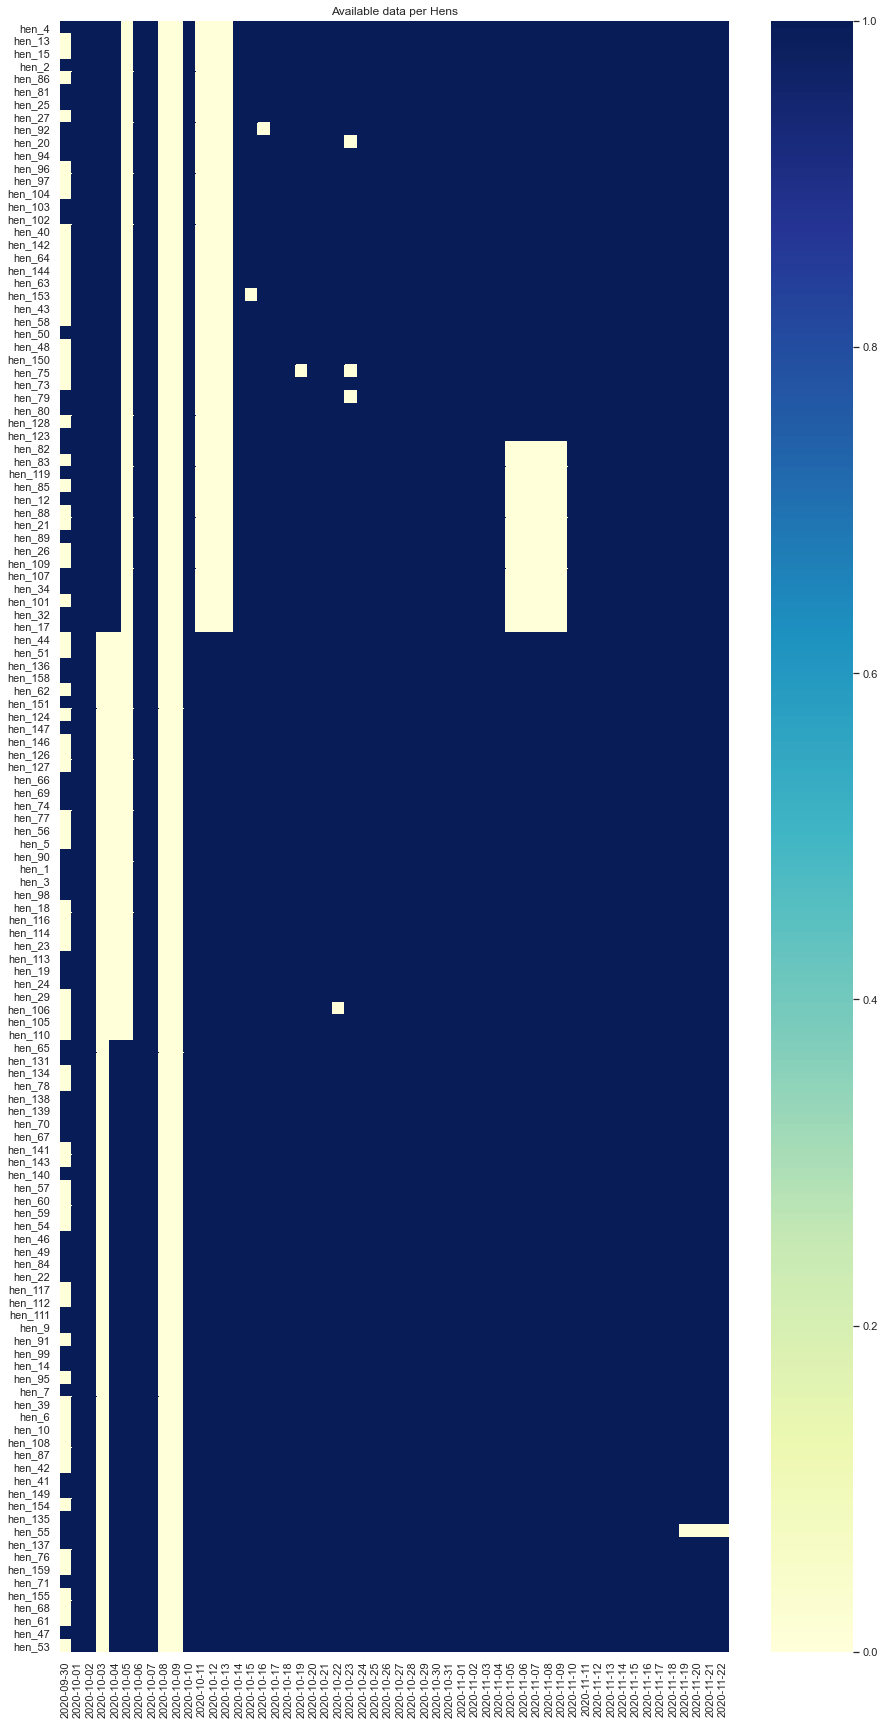

In [161]:
fig = plt.figure(figsize=(15,30))
sns.heatmap(df_plt[li_date].to_numpy(), xticklabels=li_date,  yticklabels=df_plt['HenID'].tolist(), cmap="YlGnBu")
plt.title('Available data per Hens')
plt.savefig(os.path.join(path_extracted_data_visual_adap,'DataPerHens.png'),dpi=300,format='png',bbox_inches='tight')
plt.show()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


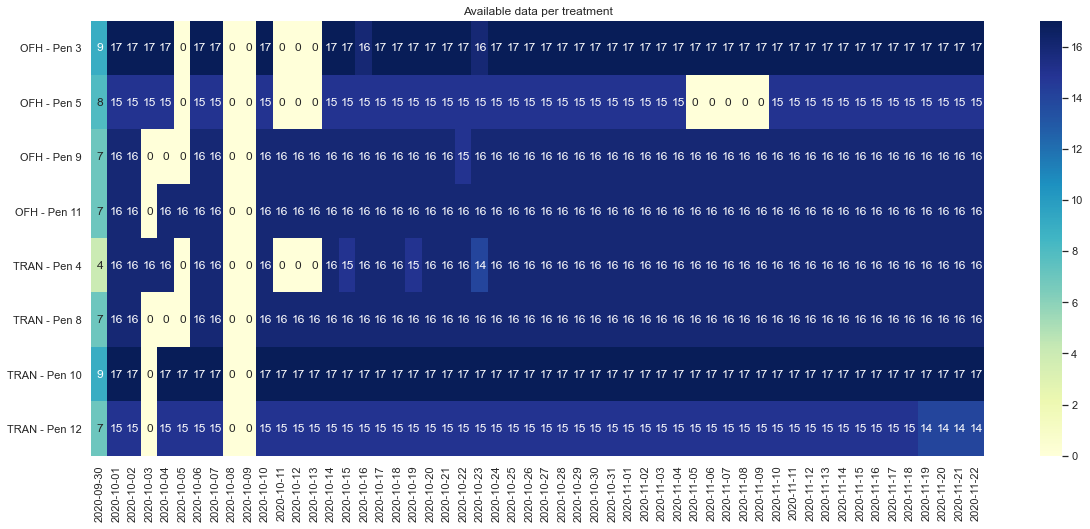

In [159]:
df_plt_summarized = df_plt.groupby(['Treatment','PenID'])[li_date].sum().reset_index()
df_plt_summarized['name'] = df_plt_summarized.apply(lambda x: x['Treatment']+' - Pen '+str(x['PenID']), axis=1)
fig = plt.figure(figsize=(20,8))
sns.heatmap(df_plt_summarized[li_date].to_numpy(), xticklabels=li_date, 
            yticklabels=df_plt_summarized['name'].tolist(), cmap="YlGnBu", annot=True)
plt.title('Available data per treatment')
plt.savefig(os.path.join(path_extracted_data_visual_adap,'DataPerTreatment.png'),dpi=300,format='png',bbox_inches='tight')
plt.show()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


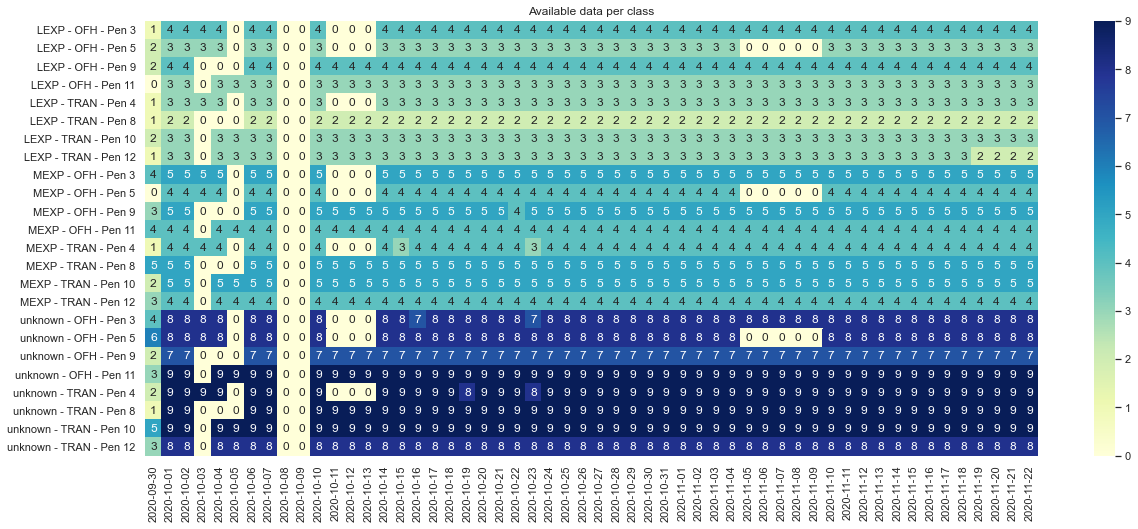

In [160]:
df_plt_summarized = df_plt.groupby(['CLASS','Treatment','PenID'])[li_date].sum().reset_index()
df_plt_summarized['name'] = df_plt_summarized.apply(lambda x: x['CLASS']+' - '+x['Treatment']+' - Pen '+str(x['PenID']), 
                                                    axis=1)
fig = plt.figure(figsize=(20,8))
sns.heatmap(df_plt_summarized[li_date].to_numpy(), xticklabels=li_date, 
            yticklabels=df_plt_summarized['name'].tolist(), cmap="YlGnBu", annot=True)
plt.title('Available data per class')
plt.savefig(os.path.join(path_extracted_data_visual_adap,'DataPerClass.png'),dpi=300,format='png',bbox_inches='tight')
plt.show()

# Overall aviary usage similarity across days

We want to assess the similarity between two consecutives days over the nestbox usage fr inter and intra individuals. 
To do so, we will first compute per 20mn(and other to chekc stability) the number of minutes in the nestbox-zone. This will then be used with the DTW in order to have a similarity measure.
Note that we dont use the birds until they have a record, as we dont know where they are... thus on the first day we are loosing XTODO birds.

DTW parameters:
https://dtaidistance.readthedocs.io/en/latest/modules/dtw.html
1. windows: "Only allow for maximal shifts from the two diagonals smaller than this number. It includes the diagonal, meaning that an Euclidean distance is obtained by setting window=1."
--> choose so taht we allow for time deformation of maximum 30 minutes (30/nbr_binmn)
2. penalty: "Penalty to add if compression or expansion is applied" (usefull to be understood: https://github.com/wannesm/dtaidistance/issues/56)
--> we choosed a penalty of 0 for now :)

Chi2 reference:
(Face Description with Local Binary Patterns: Application to Face Recognition. 2004) that Chi-Square distance perfoms better than Histogram intersection and Log-likelihood statistic.

Note: we dont remove days that have the WG opening, or nestbox opening, or light change, as this is most of the days. We will isntead focus the analysis on comparing the similarity inter vs intra, instead of each day separately quantitatif value

In [19]:
df_daily['dur_values_normalized'].fillna('[np.nan,np.nan,np.nan,np.nan,np.nan]', inplace=True)
df_daily['dur_values_normalized'] = df_daily['dur_values_normalized'].map(lambda x: eval(x))

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df['PenID'].value_counts()

In [ ]:
#for efficiency purpose let's compute the bined time series first
dico_pen_bin_zone_level_h = {}
for p, df_pen in tqdm.tqdm(df.groupby('PenID')):
    
    #update results
    dico_pen_bin_zone_level_h[p] = {}
    
    #compute time series
    df_ts = time_series_henColumn_tsRow(df_pen, config, col_ts='Zone', ts_with_all_hen_value=False, save=False, 
                                        hen_time_series=False)
    for nbr_binmn in tqdm.tqdm(li_binmn):
        #update results
        dico_pen_bin_zone_level_h[p][nbr_binmn] = {}
        
        #reduce to the interval we want
        mi = min(df_ts['Timestamp'].tolist())
        ma = max(df_ts['Timestamp'].tolist())
        #extend the end to the end of the day in case it case the last day available fo the chicken
        Daterange = pd.date_range(start = mi, end = ma+dt.timedelta(seconds=60-ma.second), 
                                  freq = str(nbr_binmn)+'MIN')    
        df_date = pd.DataFrame({str(nbr_binmn)+'mn_timestamp':Daterange})
        new_timestamp = str(nbr_binmn)+'mn_timestamp'
        df_date[new_timestamp] = df_date[new_timestamp].map(lambda x: pd.to_datetime(x))
        df_ts_ = pd.merge_asof(df_ts, df_date, left_on=['Timestamp'], right_on=[new_timestamp], direction='forward')
        #groupby the interval that we want with the number of minutes in nestbox
        li_hen = [v for v in df_ts.columns if 'hen_' in v]
        for ZONE in df['Zone'].unique():
            
            #update results
            dico_pen_bin_zone_level_h[p][nbr_binmn][ZONE] = {}
                
            df_zone_sim = df_ts_.groupby(new_timestamp)[li_hen].agg(lambda x: sum([i==ZONE for i in x])/60).reset_index()
            df_zone_sim['date'] = df_zone_sim[new_timestamp].map(lambda x: dt.datetime(x.year,x.month,x.day))

            #groupby date to have a list of zones per day (rows) for the hens (columns)
            df_zone_sim = df_zone_sim.groupby('date')[li_hen].agg(lambda x: list(x)).reset_index()
            #print(df_zone_sim.shape)
            #display(df_zone_sim.head(3))
            
            #melt to have one row per (day, hens) to avoid looping to create the dictionary
            df_zone_sim_ = pd.melt(df_zone_sim, id_vars=['date'], value_vars=li_hen)
            #variable column has the henIDs
            #print(df_zone_sim_.shape)
            #display(df_zone_sim_.head(3))
            for d, df__ in df_zone_sim_.groupby(['date']):
                #update results
                dico_pen_bin_zone_level_h[p][nbr_binmn][ZONE][d] = dict(zip(df__['variable'].tolist(), df__['value'].tolist()))
#save dictionary
pickle.dump(dico_pen_bin_zone_level_h, open(os.path.join(path_extracted_data_visual_adap, 
                                                     id_run+'dico_pen_bin_zone_level_h.pkl'), 'wb'), pickle.HIGHEST_PROTOCOL)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

in this time series there is 17 hens
The initial starting date in over all is: 2020-09-30 02:04:21, and the ending date will be: 2020-11-21 17:09:21
But note that birds may have different ending and starting date which should be taken into account when computing variables
and after ending the last day at midnight : 2020-09-30 02:04:21, and the ending date will be: 2020-11-21 23:59:59
Total running time: 1.21 mn



 14%|███████████▌                                                                     | 1/7 [11:13<1:07:20, 673.46s/it]

in this time series there is 16 hens
The initial starting date in over all is: 2020-09-30 00:01:25, and the ending date will be: 2020-11-21 21:41:30
But note that birds may have different ending and starting date which should be taken into account when computing variables
and after ending the last day at midnight : 2020-09-30 00:01:25, and the ending date will be: 2020-11-21 23:59:59
Total running time: 1.24 mn



 29%|███████████████████████▋                                                           | 2/7 [21:59<55:26, 665.33s/it]

in this time series there is 15 hens
The initial starting date in over all is: 2020-09-30 05:21:11, and the ending date will be: 2020-11-21 17:14:28
But note that birds may have different ending and starting date which should be taken into account when computing variables
and after ending the last day at midnight : 2020-09-30 05:21:11, and the ending date will be: 2020-11-21 23:59:59
Total running time: 1.20 mn



 43%|███████████████████████████████████▌                                               | 3/7 [32:19<43:26, 651.54s/it]

in this time series there is 17 hens
The initial starting date in over all is: 2020-09-30 02:41:43, and the ending date will be: 2020-11-21 21:56:07
But note that birds may have different ending and starting date which should be taken into account when computing variables
and after ending the last day at midnight : 2020-09-30 02:41:43, and the ending date will be: 2020-11-21 23:59:59
Total running time: 1.23 mn



 17%|█████████████▊                                                                     | 1/6 [01:44<08:41, 104.35s/it]

In [ ]:
#compute the chi2-distance from any two normalized vector of durations per zone that are from consectives days and same pen
li_df = []
li_zone = df['Zone'].unique()
df.sort_values(['Timestamp'], inplace=True)
for p, df_pen in tqdm.tqdm(df_daily.groupby('PenID')):
    li_date = set(df_pen['level'].tolist())
    tr = df_pen['Treatment'].unique()[0]
    for d1 in tqdm.tqdm(sorted(list(li_date))):
        doa = df_doa[df_doa['level']==d1]['DOA'].values[0]
        woa = df_doa[df_doa['level']==d1]['WOA'].values[0]
        d2 = d1+dt.timedelta(days=1)
        li_hen_d1 = df_pen[df_pen['level']==d1]['HenID'].unique()
        li_hen_d2 = df_pen[df_pen['level']==d2]['HenID'].unique()
        #its a symmetric measure, so we only do each combination once
        for h1 in li_hen_d1:
            for h2 in li_hen_d2:

                ############ Overall aviary usage similarity across days
                l1 = df_pen[(df_pen['HenID']==h1)&(df_pen['level']==d1)]['dur_values_normalized'].values[0]
                l2 = df_pen[(df_pen['HenID']==h2)&(df_pen['level']==d2)]['dur_values_normalized'].values[0]
                dico_ = {'level':d1, 'level+1':d2, 'henID1':h1, 'henID2':h2, 'PenID':p, 'Treatment':tr,
                         'dur_values_normalized_henID1':l1,'dur_values_normalized_henID2':l2,
                         'chi2distance':chi2_distance(l1,l2),'DOA':doa,'WOA':woa}
                
                ############# Specifics' zones usage similarity across days
                for nbr_binmn in li_binmn:
                    for ZONE in li_zone:
                        l1 = np.array(dico_pen_bin_zone_level_h[p][nbr_binmn][ZONE][d1][h1], dtype=np.double)
                        l2 = np.array(dico_pen_bin_zone_level_h[p][nbr_binmn][ZONE][d2][h2], dtype=np.double)

                        #compute distance measure
                        #path = dtw.warping_path(s1, s2)
                        #dtwvis.plot_warping(s1, s2, path, filename="warp.png")
                        #d = dtw.distance_fast(s1, s2)
                        penalty = 0
                        window = int(30/nbr_binmn)
                        #psi: #of start and end points of a sequence can be ignored if this would lead to a lower distance
                        d, paths = dtw.warping_paths(l1, l2, window=window, psi=0, penalty=penalty) #, max_step=0
                        if d!=np.inf:
                            d = int(round(d,0))
                        dico_['DTW_'+str(nbr_binmn)+'_'+ZONE] = d           
                li_df.append(dico_)
                
#turn inter and intra distances into a dataframe                
df_interintra = pd.DataFrame(li_df)
#df_interintra = df_interintra[~df_interintra['chi2distance'].isnull()]
df_interintra['is_same_ind'] = df_interintra.apply(lambda x: x['henID1']==x['henID2'], axis=1)
df_interintra = df_interintra.sort_values('DOA', ascending=True)
dico_name = {True: 'Intra individuals', False:'Inter individuals'}
df_interintra['type'] = df_interintra.apply(lambda x: dico_name[x['is_same_ind']]+' - '+x['Treatment'], axis=1)
#add class
df_interintra['HenID1_CLASS'] = df_interintra['henID1'].map(lambda x: df_FB[df_FB['HenID']==x]['CLASS'].values[0])
df_interintra['HenID2_CLASS'] = df_interintra['henID2'].map(lambda x: df_FB[df_FB['HenID']==x]['CLASS'].values[0])
df_interintra['CLASS'] = df_interintra.apply(lambda x:x['HenID1_CLASS']+''+x['HenID2_CLASS'], axis=1)
df_interintra['CLASS'] = df_interintra['CLASS'].replace('MEXPMEXP','MEXP')
df_interintra['CLASS'] = df_interintra['CLASS'].replace('LEXPLEXP','LEXP')
df_interintra.to_csv(os.path.join(path_extracted_data_visual_adap ,id_run+'_df_interintra.csv'), sep=';', index=False)
print(df_interintra.shape)
display(df_interintra.head(3))

In [ ]:
???#df_interintra = df_interintra[~df_interintra['chi2distance'].isnull()]

### test some DTW output

In [ ]:
df_dtw = pd.read_csv(os.path.join(path_extracted_data_visual_adap ,id_run+'_dtw_investigation.csv'), sep=';', index=False)


In [88]:
l1 = df_zonebined_sim.iloc[0]['li1']
l2 = df_zonebined_sim.iloc[0]['li2']

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [91]:
d, p = dtw.warping_paths(l1, l2, window=window, psi=0, penalty=penalty)
print(d)

30.76761013360208


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|                                                                           | 20/748560 [00:07<70:45:11,  2.94it/s]<ipython-input-106-9843748ff96d>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(15,5))
  0%|                                                                          | 651/748560 [03:54<74:46:39,  2.78it/s]


KeyboardInterrupt: 

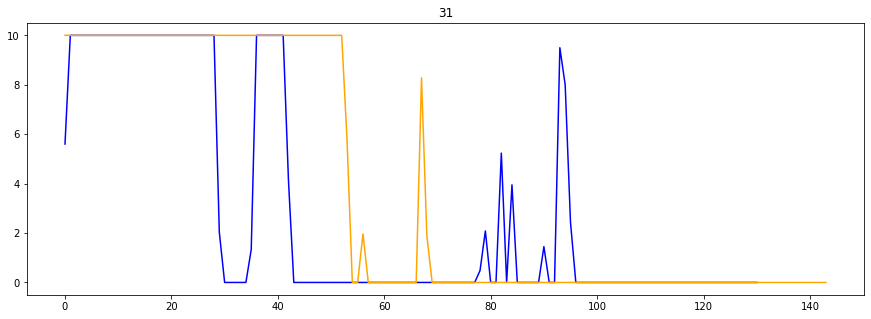

Error in callback <function flush_figures at 0x0000027A7A4F0E50> (for post_execute):


KeyboardInterrupt: 

In [106]:
for i in tqdm.tqdm(range(df_zonebined_sim.shape[0])):
    fig = plt.figure(figsize=(15,5))
    x = df_zonebined_sim.iloc[i]
    l1 = x['li1']
    l2 = x['li2']
    h1 = x['henID1']
    h2 = x['henID2']
    d = x['DTW']
    plt.plot(l1, color='blue')
    plt.plot(l2, color='orange')
    plt.title(d)
    plt.savefig(os.path.join(path_extracted_data_visual_adap_verification,str(d)+'_'+h1+'_'+h2+'.png'),
                dpi=300,format='png',bbox_inches='tight')

# Disturbance days nbr transitions per birds per 5 mn (disturbance days?)

In [ ]:
#nbr of transitions per chicken, per hour of the day
df['time'] = df['Timestamp'].map(lambda x: (x.minute*60+x.hour*60*60)/(5*60))
df_plt = df.groupby(['date','time','HenID'])['Timestamp'].agg(lambda x: len(list(x))).reset_index()
print(df_plt.shape)
display(df_plt.head(3))
#barn cleaning on thursday: first time cleaning of the barn: 8.10.2020 (i was tehre, was impressive! form 10h45 until 11h45)
fig = plt.figure(figsize=(15,5))
sns.lineplot(data=df_plt[df_plt['date']<=dt.datetime(2020,10,9)], x='time', y='Timestamp',hue='date')
#we dont see any days with abnormal amount of transitions

In [ ]:
#nbr of transitions per chicken, per hour of the day
df_plt = df.groupby(['date','hour','HenID'])['Timestamp'].agg(lambda x: len(list(x))).reset_index()
print(df_plt.shape)
display(df_plt.head(3))
#barn cleaning on thursday: 1.10.2020, 8.10.2020
fig = plt.figure(figsize=(15,5))
sns.lineplot(data=df_plt[df_plt['date']<=dt.datetime(2020,10,9)], x='hour', y='Timestamp',hue='date')
#we dont see any days with abnormal amount of transitions